In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
from __future__ import annotations

from typing import Any
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import rasterio

from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

In [ ]:
# Set credentials
config = SHConfig()
config.sh_client_id = "0fb8be04-8e2b-46cf-a1c3-8e8ebd4c9f84"
config.sh_client_secret = "MQzDaTqI0HnewCpTl2P6k1nY3sCikC8T"
config.instance_id = "sar01"

In [32]:
def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: tuple[float, float] | None = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [8]:
bbox = BBox(bbox=[12.67322755, 47.01023763, 12.70976208, 47.07509681], crs=CRS.WGS84)
size = bbox_to_dimensions(bbox, resolution=10)

In [11]:
# Evalscript for VV polarization
evalscript_s1 = """
//VERSION=3
function setup() {
  return {
    input: ["VV", "VH"],
    output: { bands: 2 }
  };
}

function evaluatePixel(sample) {
  return [sample.VV, sample.VH];
}
"""

# Download time series (2020-2024)
time_intervals = [
    ('2020-06-01', '2020-09-30'),
    ('2021-06-01', '2021-09-30'),
    ('2022-06-01', '2022-09-30'),
    ('2023-06-01', '2023-09-30'),
    ('2024-06-01', '2024-09-30'),
]

for i, time_interval in enumerate(time_intervals):
    request = SentinelHubRequest(
        evalscript=evalscript_s1,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL1_IW,
                time_interval=time_interval
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF)
        ],
        bbox=bbox,
        size=size,
        config=config
    )
    
    sar_data = request.get_data()[0]
    
    # Save
    with rasterio.open(
        f'sentinel1_{time_interval[0][:4]}.tif',
        'w',
        driver='GTiff',
        height=sar_data.shape[0],
        width=sar_data.shape[1],
        count=2,
        dtype=sar_data.dtype,
        crs='EPSG:4326',
        transform=rasterio.transform.from_bounds(*bbox, sar_data.shape[1], sar_data.shape[0])
    ) as dst:
        dst.write(sar_data[:,:,0], 1)
        dst.write(sar_data[:,:,1], 2)
    
    print(f"Downloaded SAR data for {time_interval[0][:4]}")

Downloaded SAR data for 2020
Downloaded SAR data for 2021
Downloaded SAR data for 2022
Downloaded SAR data for 2023
Downloaded SAR data for 2024


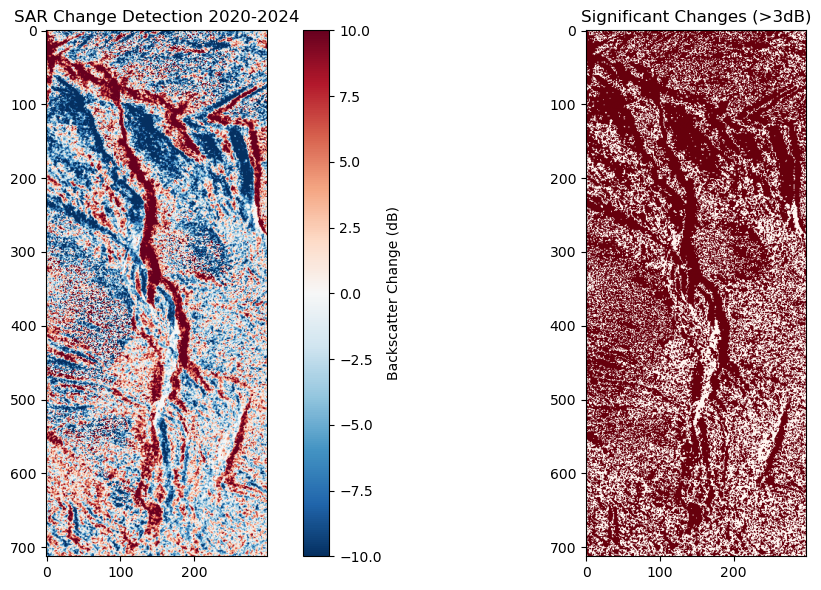

In [12]:
# Load two time periods
with rasterio.open('sentinel1_2020.tif') as src:
    sar_2020_vv = src.read(1)

with rasterio.open('sentinel1_2024.tif') as src:
    sar_2024_vv = src.read(1)

# Calculate ratio (dB difference)
sar_2020_db = 10 * np.log10(sar_2020_vv + 1e-10)
sar_2024_db = 10 * np.log10(sar_2024_vv + 1e-10)

sar_change = sar_2024_db - sar_2020_db

# Significant changes (threshold = ±3 dB)
significant_change = np.abs(sar_change) > 3

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(sar_change, cmap='RdBu_r', vmin=-10, vmax=10)
plt.colorbar(label='Backscatter Change (dB)')
plt.title('SAR Change Detection 2020-2024')

plt.subplot(1, 2, 2)
plt.imshow(significant_change, cmap='Reds')
plt.title('Significant Changes (>3dB)')

plt.tight_layout()
plt.savefig('14_sar_change_detection.png', dpi=150)